### Prisioner's Dilemma

- There are two agents that interact in repeated prisioner's dilemma. 
- Actions are: defect (D/0) or confess (C/1).
- Rewards for agents are 

    - (2,2) for (D,D) 
    - (0,3) for (D,C) 
    - (3,0) for (C,D) 
    - (1,1) for (C,C)

- There is just one state that does not change. State does not play a role here, it is just a placeholder. 
- There is "discounting". Agents value future profits. 
- The Nash Eqbm is (C,C) where both agents confess and end up getting a bad outcome for themselves. 
- This is because D is a strictly dominanted strategy, regardless of what the other plays.

### Import Packages

In [1]:
from itertools import count
import torch
import math
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams['font.size']=20

### Helper Functions

In [2]:
def gameReward(a1,a2):
    if (a1 == 0 and a2 == 0): # DD
        return (2,2)
    if (a1 == 0 and a2 == 1): # DC
        return (0,3)
    if (a1 == 1 and a2 == 0): # CD
        return (3,0)
    if (a1 == 1 and a2 == 1): # CD
        return (1,1)
    
    
import random
from collections import namedtuple, deque
Transition = namedtuple('Transition',('state','next_state','a1','a2','r1','r2'))

class ReplayMemory(object):
    # Holds transitions from experience and gives a random batch of transitions for training
    def __init__(self,capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self,*args):
        "save transition"
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    # Input: State
    # Output: 0,1
    # Network is going to try to predict the expected Return of taking each action given the INPUT
    def __init__(self, n_obs, n_actions):
        super(DQN,self).__init__()
        self.layer1 = nn.Linear(n_obs, 128)
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128, n_actions)
    
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)   


def select_action(state, policy_net, idx):
    # Given state selects action either from the DQN or randomly. 
    global steps_done1, steps_done2
    sample = random.random()
    if idx == 0:
        eps_threshold = EPS_END + (EPS_START-EPS_END)*math.exp(-1.*steps_done1/EPS_DECAY)
        steps_done1 += 1
    else:
        eps_threshold = EPS_END + (EPS_START-EPS_END)*math.exp(-1.*steps_done2/EPS_DECAY)
        steps_done2 += 1
    
    if sample>eps_threshold:
        with torch.no_grad():
            try: 
                return policy_net(state).max(1)[1].view(1,1) # pick up action with largest expected reward
            except:
                return policy_net(state).max(0)[1].view(1,1) # pick up action with largest expected reward
    else:
        randchoice = random.choice([0,1])
        return torch.tensor([[randchoice]],dtype=torch.long)
    
def update_target_net(target_net, policy_net):
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*TAU+target_net_state_dict[key]*(1-TAU)
    target_net.load_state_dict(target_net_state_dict)

def optimize_model(policy_net,target_net,idx):
    if len(memory)<BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    # final state is after simulation is done
    # these are the "s(t+1)" from the transitions
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    # we begin with a batch of transitions - (state, action, reward)
    state_batch = torch.cat(batch.state)
    if idx == 0:
        action_batch = torch.cat(batch.a1)
        reward_batch = torch.cat(batch.r1)
    elif idx == 1:
        action_batch = torch.cat(batch.a2)
        reward_batch = torch.cat(batch.r2)
    
    # For these batch states we compute optimal policy according to our policy-network
    # Compute Q(s,a) and get actions - these are the actions that would have been taken for each batch state 
    state_action_values = policy_net(state_batch.reshape(-1,1)).gather(1,action_batch)
    
    # Compute V(s_t+1)
    next_state_values = torch.zeros(BATCH_SIZE)
    with torch.no_grad():
        # Use the "old" target_net to obtain value (Expected Return) on optimal actions from sampled s(t+1)
        # This is Q_old(s',a')
        next_state_values[non_final_mask] = target_net(non_final_next_states.reshape(-1,1)).max(1)[0]
        
    # Here we have add r + max Q_old(s',a')
    expected_state_action_values = (next_state_values*GAMMA)+reward_batch

    # Compute the loss
    # Q_new(s,a) - r + max Q_old(s',a'): is the error
    # Huber loss function
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values,expected_state_action_values.unsqueeze(1))
    if idx == 0:
        optimizer1.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(policy_net1.parameters(),100)
        optimizer1.step()
    elif idx == 1:
        optimizer2.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(policy_net2.parameters(),100)
        optimizer2.step()
    print(f'Loss Agent{idx}:{loss.item()}')

### HyperParameters and Initializations

In [3]:
BATCH_SIZE = 128 # number of transitions sampled from replay buffer
GAMMA = 0.99 # Discount factor
EPS_START = 0.99 # Initial value of Epsilon
EPS_END = 0.05 # End value of Epsilon
EPS_DECAY = 1000 # controls decay rate of Epsilon
TAU = 0.0005 # update rate of target network
LR = 1e-5 # Learning rate of Adam
n_obs = 1
n_actions = 2
policy_net1 = DQN(n_obs,n_actions)
target_net1 = DQN(n_obs,n_actions)
policy_net2 = DQN(n_obs,n_actions)
target_net2 = DQN(n_obs,n_actions)
steps_done1 = 0
steps_done2 = 0
optimizer1 = optim.AdamW(policy_net1.parameters(),lr=LR,amsgrad=True)
optimizer2 = optim.AdamW(policy_net2.parameters(),lr=LR,amsgrad=True)
memory=ReplayMemory(10000)

### Training Loop

In [4]:
state = torch.tensor(1,dtype=torch.float32).unsqueeze(0)
actions = []
epochs = 5000
for t in range(epochs):
    print('\n Iteration:',t)
    # Take action
    a1 = select_action(state, policy_net1, 0)
    a2 = select_action(state, policy_net2, 1)

    # Obtain Rewards
    r1, r2 = gameReward(int(a1),int(a2))
    r1 = torch.tensor([r1])
    r2 = torch.tensor([r2])

    # Compute next state
    next_state = torch.tensor(1,dtype=torch.float32).unsqueeze(0)

    # store memory in transition
    memory.push(state,next_state,a1,a2,r1,r2)

    # move to next state
    state = next_state

    # optimize
    optimize_model(policy_net1,target_net1, 0)
    optimize_model(policy_net2,target_net2, 1)

    # soft update target_net
    update_target_net(target_net1, policy_net1)
    update_target_net(target_net2, policy_net2)
    
    # record actions
    actions.append([a1.item(),a2.item()])


 Iteration: 0

 Iteration: 1

 Iteration: 2

 Iteration: 3

 Iteration: 4

 Iteration: 5

 Iteration: 6

 Iteration: 7

 Iteration: 8

 Iteration: 9

 Iteration: 10

 Iteration: 11

 Iteration: 12

 Iteration: 13

 Iteration: 14

 Iteration: 15

 Iteration: 16

 Iteration: 17

 Iteration: 18

 Iteration: 19

 Iteration: 20

 Iteration: 21

 Iteration: 22

 Iteration: 23

 Iteration: 24

 Iteration: 25

 Iteration: 26

 Iteration: 27

 Iteration: 28

 Iteration: 29

 Iteration: 30

 Iteration: 31

 Iteration: 32

 Iteration: 33

 Iteration: 34

 Iteration: 35

 Iteration: 36

 Iteration: 37

 Iteration: 38

 Iteration: 39

 Iteration: 40

 Iteration: 41

 Iteration: 42

 Iteration: 43

 Iteration: 44

 Iteration: 45

 Iteration: 46

 Iteration: 47

 Iteration: 48

 Iteration: 49

 Iteration: 50

 Iteration: 51

 Iteration: 52

 Iteration: 53

 Iteration: 54

 Iteration: 55

 Iteration: 56

 Iteration: 57

 Iteration: 58

 Iteration: 59

 Iteration: 60

 Iteration: 61

 Iteration: 62

 

Loss Agent0:1.360941767692566
Loss Agent1:1.0890601873397827

 Iteration: 214
Loss Agent0:1.4727931022644043
Loss Agent1:0.9790830016136169

 Iteration: 215
Loss Agent0:1.3160393238067627
Loss Agent1:0.9465917348861694

 Iteration: 216
Loss Agent0:1.2694474458694458
Loss Agent1:0.8987489938735962

 Iteration: 217
Loss Agent0:1.3438798189163208
Loss Agent1:1.0054142475128174

 Iteration: 218
Loss Agent0:1.4193896055221558
Loss Agent1:1.0094221830368042

 Iteration: 219
Loss Agent0:1.4478037357330322
Loss Agent1:1.0348137617111206

 Iteration: 220
Loss Agent0:1.2612760066986084
Loss Agent1:0.912117600440979

 Iteration: 221
Loss Agent0:1.3404147624969482
Loss Agent1:1.1018770933151245

 Iteration: 222
Loss Agent0:1.2931363582611084
Loss Agent1:0.9807757139205933

 Iteration: 223
Loss Agent0:1.3253087997436523
Loss Agent1:0.9705764651298523

 Iteration: 224
Loss Agent0:1.3657692670822144
Loss Agent1:0.9715429544448853

 Iteration: 225
Loss Agent0:1.346771478652954
Loss Agent1:1.0875831842

Loss Agent0:1.1980429887771606
Loss Agent1:1.022296667098999

 Iteration: 328
Loss Agent0:1.1652703285217285
Loss Agent1:1.1134706735610962

 Iteration: 329
Loss Agent0:1.163800597190857
Loss Agent1:0.8916924595832825

 Iteration: 330
Loss Agent0:1.2219727039337158
Loss Agent1:1.1154425144195557

 Iteration: 331
Loss Agent0:1.0437482595443726
Loss Agent1:0.981414794921875

 Iteration: 332
Loss Agent0:1.2375409603118896
Loss Agent1:0.9732008576393127

 Iteration: 333
Loss Agent0:1.3096015453338623
Loss Agent1:0.9217942357063293

 Iteration: 334
Loss Agent0:1.1355170011520386
Loss Agent1:0.9448013305664062

 Iteration: 335
Loss Agent0:1.068203091621399
Loss Agent1:0.9790338277816772

 Iteration: 336
Loss Agent0:1.1537928581237793
Loss Agent1:0.985476016998291

 Iteration: 337
Loss Agent0:1.2830262184143066
Loss Agent1:0.9803624749183655

 Iteration: 338
Loss Agent0:1.232679843902588
Loss Agent1:0.9968999624252319

 Iteration: 339
Loss Agent0:1.1306763887405396
Loss Agent1:0.9505636096000

Loss Agent1:0.9920303821563721

 Iteration: 444
Loss Agent0:1.1365458965301514
Loss Agent1:0.9639571905136108

 Iteration: 445
Loss Agent0:1.0013713836669922
Loss Agent1:1.0767117738723755

 Iteration: 446
Loss Agent0:1.00496506690979
Loss Agent1:0.9247411489486694

 Iteration: 447
Loss Agent0:1.0780820846557617
Loss Agent1:0.8843063116073608

 Iteration: 448
Loss Agent0:1.0296244621276855
Loss Agent1:0.9186363816261292

 Iteration: 449
Loss Agent0:0.8806055784225464
Loss Agent1:0.9532337784767151

 Iteration: 450
Loss Agent0:0.9477609992027283
Loss Agent1:1.026047706604004

 Iteration: 451
Loss Agent0:1.0084339380264282
Loss Agent1:0.8650385737419128

 Iteration: 452
Loss Agent0:1.0298881530761719
Loss Agent1:0.9992812275886536

 Iteration: 453
Loss Agent0:1.049255609512329
Loss Agent1:0.9220879673957825

 Iteration: 454
Loss Agent0:1.0624717473983765
Loss Agent1:0.9458405375480652

 Iteration: 455
Loss Agent0:1.0349841117858887
Loss Agent1:0.9902126789093018

 Iteration: 456
Loss Age

Loss Agent1:0.9037612080574036

 Iteration: 559
Loss Agent0:0.8478070497512817
Loss Agent1:0.8916661739349365

 Iteration: 560
Loss Agent0:0.9199633598327637
Loss Agent1:0.9140080213546753

 Iteration: 561
Loss Agent0:0.8581845164299011
Loss Agent1:0.8627206683158875

 Iteration: 562
Loss Agent0:0.8977530002593994
Loss Agent1:0.8591331839561462

 Iteration: 563
Loss Agent0:0.8465306758880615
Loss Agent1:0.8784687519073486

 Iteration: 564
Loss Agent0:1.0510118007659912
Loss Agent1:0.8493971824645996

 Iteration: 565
Loss Agent0:0.936841607093811
Loss Agent1:0.9102065563201904

 Iteration: 566
Loss Agent0:0.847120463848114
Loss Agent1:0.9599796533584595

 Iteration: 567
Loss Agent0:0.8134937286376953
Loss Agent1:0.8617156147956848

 Iteration: 568
Loss Agent0:0.8109299540519714
Loss Agent1:0.8220064043998718

 Iteration: 569
Loss Agent0:0.8185832500457764
Loss Agent1:0.943284809589386

 Iteration: 570
Loss Agent0:0.9200981855392456
Loss Agent1:0.7929632663726807

 Iteration: 571
Loss Ag

Loss Agent0:0.8123687505722046
Loss Agent1:0.7887557148933411

 Iteration: 667
Loss Agent0:0.8653353452682495
Loss Agent1:0.798862099647522

 Iteration: 668
Loss Agent0:0.8134499192237854
Loss Agent1:0.6735531091690063

 Iteration: 669
Loss Agent0:0.8773608803749084
Loss Agent1:0.8497195243835449

 Iteration: 670
Loss Agent0:0.8002305626869202
Loss Agent1:0.7889426946640015

 Iteration: 671
Loss Agent0:0.9119958877563477
Loss Agent1:0.8144418001174927

 Iteration: 672
Loss Agent0:0.7971850633621216
Loss Agent1:0.7772508859634399

 Iteration: 673
Loss Agent0:0.7915096879005432
Loss Agent1:0.8911406993865967

 Iteration: 674
Loss Agent0:0.7480080127716064
Loss Agent1:0.7355658411979675

 Iteration: 675
Loss Agent0:0.743144690990448
Loss Agent1:0.8263892531394958

 Iteration: 676
Loss Agent0:0.7750378847122192
Loss Agent1:0.6839464902877808

 Iteration: 677
Loss Agent0:0.762380063533783
Loss Agent1:0.7983383536338806

 Iteration: 678
Loss Agent0:0.7234949469566345
Loss Agent1:0.7464759349

Loss Agent1:0.7337321043014526

 Iteration: 775
Loss Agent0:0.7398151755332947
Loss Agent1:0.6427229642868042

 Iteration: 776
Loss Agent0:0.6552799940109253
Loss Agent1:0.6968919038772583

 Iteration: 777
Loss Agent0:0.7859857678413391
Loss Agent1:0.6678704619407654

 Iteration: 778
Loss Agent0:0.6785216331481934
Loss Agent1:0.5730741620063782

 Iteration: 779
Loss Agent0:0.7292715907096863
Loss Agent1:0.702121913433075

 Iteration: 780
Loss Agent0:0.6693916320800781
Loss Agent1:0.7150267958641052

 Iteration: 781
Loss Agent0:0.600610613822937
Loss Agent1:0.7504923939704895

 Iteration: 782
Loss Agent0:0.7476410865783691
Loss Agent1:0.7225542068481445

 Iteration: 783
Loss Agent0:0.6495434641838074
Loss Agent1:0.7502956390380859

 Iteration: 784
Loss Agent0:0.669705331325531
Loss Agent1:0.7016147971153259

 Iteration: 785
Loss Agent0:0.6717442274093628
Loss Agent1:0.7001142501831055

 Iteration: 786
Loss Agent0:0.6611340641975403
Loss Agent1:0.7357563376426697

 Iteration: 787
Loss Ag

Loss Agent0:0.6409763097763062
Loss Agent1:0.644759476184845

 Iteration: 887
Loss Agent0:0.6339336037635803
Loss Agent1:0.5456445217132568

 Iteration: 888
Loss Agent0:0.6148080229759216
Loss Agent1:0.6267160177230835

 Iteration: 889
Loss Agent0:0.5732986927032471
Loss Agent1:0.6089999675750732

 Iteration: 890
Loss Agent0:0.6900385022163391
Loss Agent1:0.6031763553619385

 Iteration: 891
Loss Agent0:0.6521674990653992
Loss Agent1:0.5841994285583496

 Iteration: 892
Loss Agent0:0.5144163966178894
Loss Agent1:0.4726247787475586

 Iteration: 893
Loss Agent0:0.5653735995292664
Loss Agent1:0.5391380786895752

 Iteration: 894
Loss Agent0:0.6824331283569336
Loss Agent1:0.5585276484489441

 Iteration: 895
Loss Agent0:0.6732921600341797
Loss Agent1:0.6409538984298706

 Iteration: 896
Loss Agent0:0.5968284010887146
Loss Agent1:0.6485426425933838

 Iteration: 897
Loss Agent0:0.5577341318130493
Loss Agent1:0.520950436592102

 Iteration: 898
Loss Agent0:0.6823832988739014
Loss Agent1:0.494410127

Loss Agent0:0.6681867837905884
Loss Agent1:0.4440543055534363

 Iteration: 997
Loss Agent0:0.65601646900177
Loss Agent1:0.5060299038887024

 Iteration: 998
Loss Agent0:0.4961268901824951
Loss Agent1:0.5074828267097473

 Iteration: 999
Loss Agent0:0.5511969923973083
Loss Agent1:0.5088717341423035

 Iteration: 1000
Loss Agent0:0.6134644746780396
Loss Agent1:0.5736715197563171

 Iteration: 1001
Loss Agent0:0.5537924766540527
Loss Agent1:0.5298424363136292

 Iteration: 1002
Loss Agent0:0.5335144400596619
Loss Agent1:0.5880486369132996

 Iteration: 1003
Loss Agent0:0.48112013936042786
Loss Agent1:0.5317531824111938

 Iteration: 1004
Loss Agent0:0.5020298361778259
Loss Agent1:0.6195111870765686

 Iteration: 1005
Loss Agent0:0.6059913635253906
Loss Agent1:0.46911299228668213

 Iteration: 1006
Loss Agent0:0.5035861134529114
Loss Agent1:0.46547362208366394

 Iteration: 1007
Loss Agent0:0.5397490859031677
Loss Agent1:0.5396620035171509

 Iteration: 1008
Loss Agent0:0.5500776171684265
Loss Agent1

Loss Agent0:0.4795266091823578
Loss Agent1:0.45593950152397156

 Iteration: 1105
Loss Agent0:0.4755505323410034
Loss Agent1:0.503944456577301

 Iteration: 1106
Loss Agent0:0.5348140597343445
Loss Agent1:0.46402889490127563

 Iteration: 1107
Loss Agent0:0.48173245787620544
Loss Agent1:0.42342716455459595

 Iteration: 1108
Loss Agent0:0.4548902213573456
Loss Agent1:0.5124611258506775

 Iteration: 1109
Loss Agent0:0.5010471343994141
Loss Agent1:0.4931809604167938

 Iteration: 1110
Loss Agent0:0.5141287446022034
Loss Agent1:0.4270629584789276

 Iteration: 1111
Loss Agent0:0.398044228553772
Loss Agent1:0.4794352054595947

 Iteration: 1112
Loss Agent0:0.4207485318183899
Loss Agent1:0.5035995244979858

 Iteration: 1113
Loss Agent0:0.46040719747543335
Loss Agent1:0.45030272006988525

 Iteration: 1114
Loss Agent0:0.42066341638565063
Loss Agent1:0.536838710308075

 Iteration: 1115
Loss Agent0:0.440020889043808
Loss Agent1:0.4893322288990021

 Iteration: 1116
Loss Agent0:0.5186904072761536
Loss A

Loss Agent0:0.318052738904953
Loss Agent1:0.4170951247215271

 Iteration: 1212
Loss Agent0:0.4147419333457947
Loss Agent1:0.47760114073753357

 Iteration: 1213
Loss Agent0:0.46948111057281494
Loss Agent1:0.42649874091148376

 Iteration: 1214
Loss Agent0:0.46411067247390747
Loss Agent1:0.4620097875595093

 Iteration: 1215
Loss Agent0:0.4192500710487366
Loss Agent1:0.45434069633483887

 Iteration: 1216
Loss Agent0:0.4754965305328369
Loss Agent1:0.44903385639190674

 Iteration: 1217
Loss Agent0:0.48943090438842773
Loss Agent1:0.4293605089187622

 Iteration: 1218
Loss Agent0:0.4131155014038086
Loss Agent1:0.46698740124702454

 Iteration: 1219
Loss Agent0:0.4421645998954773
Loss Agent1:0.5057276487350464

 Iteration: 1220
Loss Agent0:0.37348103523254395
Loss Agent1:0.5085009932518005

 Iteration: 1221
Loss Agent0:0.5582205653190613
Loss Agent1:0.43086251616477966

 Iteration: 1222
Loss Agent0:0.5143955945968628
Loss Agent1:0.45384910702705383

 Iteration: 1223
Loss Agent0:0.5326035618782043

Loss Agent1:0.37902167439460754

 Iteration: 1314
Loss Agent0:0.4456685483455658
Loss Agent1:0.5127040147781372

 Iteration: 1315
Loss Agent0:0.4708719253540039
Loss Agent1:0.40311652421951294

 Iteration: 1316
Loss Agent0:0.4724130630493164
Loss Agent1:0.46090131998062134

 Iteration: 1317
Loss Agent0:0.39697209000587463
Loss Agent1:0.4337998032569885

 Iteration: 1318
Loss Agent0:0.4168928861618042
Loss Agent1:0.4034401476383209

 Iteration: 1319
Loss Agent0:0.35443174839019775
Loss Agent1:0.38921764492988586

 Iteration: 1320
Loss Agent0:0.5399890542030334
Loss Agent1:0.44803375005722046

 Iteration: 1321
Loss Agent0:0.4315817356109619
Loss Agent1:0.45930910110473633

 Iteration: 1322
Loss Agent0:0.4298321604728699
Loss Agent1:0.4043445289134979

 Iteration: 1323
Loss Agent0:0.4716978669166565
Loss Agent1:0.41978004574775696

 Iteration: 1324
Loss Agent0:0.39969968795776367
Loss Agent1:0.45344775915145874

 Iteration: 1325
Loss Agent0:0.4313649535179138
Loss Agent1:0.443284273147583

Loss Agent0:0.3381112217903137
Loss Agent1:0.3192773461341858

 Iteration: 1417
Loss Agent0:0.37193265557289124
Loss Agent1:0.47890034317970276

 Iteration: 1418
Loss Agent0:0.3885018825531006
Loss Agent1:0.46104124188423157

 Iteration: 1419
Loss Agent0:0.3846835196018219
Loss Agent1:0.3548782765865326

 Iteration: 1420
Loss Agent0:0.3707227408885956
Loss Agent1:0.40292322635650635

 Iteration: 1421
Loss Agent0:0.41860470175743103
Loss Agent1:0.4396493434906006

 Iteration: 1422
Loss Agent0:0.4099152982234955
Loss Agent1:0.37148404121398926

 Iteration: 1423
Loss Agent0:0.39038151502609253
Loss Agent1:0.3346511423587799

 Iteration: 1424
Loss Agent0:0.42434871196746826
Loss Agent1:0.5411468148231506

 Iteration: 1425
Loss Agent0:0.39572831988334656
Loss Agent1:0.40919485688209534

 Iteration: 1426
Loss Agent0:0.36739251017570496
Loss Agent1:0.45868077874183655

 Iteration: 1427
Loss Agent0:0.36142149567604065
Loss Agent1:0.3955543041229248

 Iteration: 1428
Loss Agent0:0.4182140529155

Loss Agent0:0.4638849198818207
Loss Agent1:0.44414007663726807

 Iteration: 1524
Loss Agent0:0.2649343013763428
Loss Agent1:0.42576128244400024

 Iteration: 1525
Loss Agent0:0.27638086676597595
Loss Agent1:0.3672233819961548

 Iteration: 1526
Loss Agent0:0.4397141635417938
Loss Agent1:0.3952774405479431

 Iteration: 1527
Loss Agent0:0.390933632850647
Loss Agent1:0.3680069148540497

 Iteration: 1528
Loss Agent0:0.42990684509277344
Loss Agent1:0.38531091809272766

 Iteration: 1529
Loss Agent0:0.4313404858112335
Loss Agent1:0.46730032563209534

 Iteration: 1530
Loss Agent0:0.3260834217071533
Loss Agent1:0.37157025933265686

 Iteration: 1531
Loss Agent0:0.45444029569625854
Loss Agent1:0.373216837644577

 Iteration: 1532
Loss Agent0:0.29666680097579956
Loss Agent1:0.36121779680252075

 Iteration: 1533
Loss Agent0:0.42646995186805725
Loss Agent1:0.3664139211177826

 Iteration: 1534
Loss Agent0:0.3026534616947174
Loss Agent1:0.39190560579299927

 Iteration: 1535
Loss Agent0:0.2926576733589172

Loss Agent0:0.39772355556488037
Loss Agent1:0.4369809627532959

 Iteration: 1627
Loss Agent0:0.4552111029624939
Loss Agent1:0.35721877217292786

 Iteration: 1628
Loss Agent0:0.3541320264339447
Loss Agent1:0.4317373037338257

 Iteration: 1629
Loss Agent0:0.3337172567844391
Loss Agent1:0.41633063554763794

 Iteration: 1630
Loss Agent0:0.3829815089702606
Loss Agent1:0.3696627616882324

 Iteration: 1631
Loss Agent0:0.3921274244785309
Loss Agent1:0.3990020155906677

 Iteration: 1632
Loss Agent0:0.31869956851005554
Loss Agent1:0.3999464809894562

 Iteration: 1633
Loss Agent0:0.3971734046936035
Loss Agent1:0.38696393370628357

 Iteration: 1634
Loss Agent0:0.29269012808799744
Loss Agent1:0.4434412121772766

 Iteration: 1635
Loss Agent0:0.2832624018192291
Loss Agent1:0.37852299213409424

 Iteration: 1636
Loss Agent0:0.29921355843544006
Loss Agent1:0.3797720670700073

 Iteration: 1637
Loss Agent0:0.2800898253917694
Loss Agent1:0.3422549068927765

 Iteration: 1638
Loss Agent0:0.3271479606628418
L

Loss Agent0:0.2617945671081543
Loss Agent1:0.3269345164299011

 Iteration: 1731
Loss Agent0:0.35776641964912415
Loss Agent1:0.3048909902572632

 Iteration: 1732
Loss Agent0:0.2924789488315582
Loss Agent1:0.40646252036094666

 Iteration: 1733
Loss Agent0:0.32829564809799194
Loss Agent1:0.31998100876808167

 Iteration: 1734
Loss Agent0:0.3820592761039734
Loss Agent1:0.3379794955253601

 Iteration: 1735
Loss Agent0:0.41949838399887085
Loss Agent1:0.36336639523506165

 Iteration: 1736
Loss Agent0:0.33562710881233215
Loss Agent1:0.4002411961555481

 Iteration: 1737
Loss Agent0:0.3016375005245209
Loss Agent1:0.31282171607017517

 Iteration: 1738
Loss Agent0:0.2815568447113037
Loss Agent1:0.397626668214798

 Iteration: 1739
Loss Agent0:0.285775750875473
Loss Agent1:0.28599727153778076

 Iteration: 1740
Loss Agent0:0.4025367200374603
Loss Agent1:0.3709884285926819

 Iteration: 1741
Loss Agent0:0.31204548478126526
Loss Agent1:0.40237659215927124

 Iteration: 1742
Loss Agent0:0.2473088949918747


Loss Agent0:0.3639649748802185
Loss Agent1:0.3382057547569275

 Iteration: 1843
Loss Agent0:0.28388068079948425
Loss Agent1:0.3533366024494171

 Iteration: 1844
Loss Agent0:0.33665433526039124
Loss Agent1:0.37341123819351196

 Iteration: 1845
Loss Agent0:0.36038917303085327
Loss Agent1:0.34250709414482117

 Iteration: 1846
Loss Agent0:0.25832414627075195
Loss Agent1:0.37342098355293274

 Iteration: 1847
Loss Agent0:0.3642529547214508
Loss Agent1:0.36463823914527893

 Iteration: 1848
Loss Agent0:0.328164279460907
Loss Agent1:0.3480447828769684

 Iteration: 1849
Loss Agent0:0.29302671551704407
Loss Agent1:0.3543098270893097

 Iteration: 1850
Loss Agent0:0.37667223811149597
Loss Agent1:0.40966933965682983

 Iteration: 1851
Loss Agent0:0.36178237199783325
Loss Agent1:0.35909929871559143

 Iteration: 1852
Loss Agent0:0.39957723021507263
Loss Agent1:0.3797357976436615

 Iteration: 1853
Loss Agent0:0.34250178933143616
Loss Agent1:0.34451010823249817

 Iteration: 1854
Loss Agent0:0.35932216048

Loss Agent0:0.3757025897502899
Loss Agent1:0.31009313464164734

 Iteration: 1948
Loss Agent0:0.29696306586265564
Loss Agent1:0.4118538498878479

 Iteration: 1949
Loss Agent0:0.3127151131629944
Loss Agent1:0.34406429529190063

 Iteration: 1950
Loss Agent0:0.25173136591911316
Loss Agent1:0.2708243131637573

 Iteration: 1951
Loss Agent0:0.27460023760795593
Loss Agent1:0.37768521904945374

 Iteration: 1952
Loss Agent0:0.3831188678741455
Loss Agent1:0.3103313446044922

 Iteration: 1953
Loss Agent0:0.2289276421070099
Loss Agent1:0.33318743109703064

 Iteration: 1954
Loss Agent0:0.34736955165863037
Loss Agent1:0.27282339334487915

 Iteration: 1955
Loss Agent0:0.376009076833725
Loss Agent1:0.3372880816459656

 Iteration: 1956
Loss Agent0:0.3389805257320404
Loss Agent1:0.35130003094673157

 Iteration: 1957
Loss Agent0:0.23232989013195038
Loss Agent1:0.37999066710472107

 Iteration: 1958
Loss Agent0:0.33952972292900085
Loss Agent1:0.357770174741745

 Iteration: 1959
Loss Agent0:0.281881928443908


 Iteration: 2051
Loss Agent0:0.3366146385669708
Loss Agent1:0.3916010856628418

 Iteration: 2052
Loss Agent0:0.30140843987464905
Loss Agent1:0.3556841015815735

 Iteration: 2053
Loss Agent0:0.31231826543807983
Loss Agent1:0.33690109848976135

 Iteration: 2054
Loss Agent0:0.27734091877937317
Loss Agent1:0.33810704946517944

 Iteration: 2055
Loss Agent0:0.29757413268089294
Loss Agent1:0.4223622977733612

 Iteration: 2056
Loss Agent0:0.3819229006767273
Loss Agent1:0.3316766023635864

 Iteration: 2057
Loss Agent0:0.2988723814487457
Loss Agent1:0.31751999258995056

 Iteration: 2058
Loss Agent0:0.322413831949234
Loss Agent1:0.3398762047290802

 Iteration: 2059
Loss Agent0:0.3146785497665405
Loss Agent1:0.44156068563461304

 Iteration: 2060
Loss Agent0:0.2776733934879303
Loss Agent1:0.31057271361351013

 Iteration: 2061
Loss Agent0:0.35918182134628296
Loss Agent1:0.37841859459877014

 Iteration: 2062
Loss Agent0:0.28744766116142273
Loss Agent1:0.3175097703933716

 Iteration: 2063
Loss Agent0

Loss Agent1:0.26671627163887024

 Iteration: 2155
Loss Agent0:0.3108910918235779
Loss Agent1:0.28505373001098633

 Iteration: 2156
Loss Agent0:0.3464675545692444
Loss Agent1:0.36315253376960754

 Iteration: 2157
Loss Agent0:0.28844785690307617
Loss Agent1:0.3575146496295929

 Iteration: 2158
Loss Agent0:0.35523757338523865
Loss Agent1:0.40733033418655396

 Iteration: 2159
Loss Agent0:0.2707299590110779
Loss Agent1:0.3248891830444336

 Iteration: 2160
Loss Agent0:0.3806430697441101
Loss Agent1:0.42181912064552307

 Iteration: 2161
Loss Agent0:0.28844571113586426
Loss Agent1:0.35313230752944946

 Iteration: 2162
Loss Agent0:0.31190571188926697
Loss Agent1:0.2932208180427551

 Iteration: 2163
Loss Agent0:0.3176616132259369
Loss Agent1:0.32967373728752136

 Iteration: 2164
Loss Agent0:0.306759774684906
Loss Agent1:0.3207206130027771

 Iteration: 2165
Loss Agent0:0.3790792226791382
Loss Agent1:0.24983438849449158

 Iteration: 2166
Loss Agent0:0.25696298480033875
Loss Agent1:0.35631549358367

Loss Agent0:0.35986635088920593
Loss Agent1:0.400769978761673

 Iteration: 2262
Loss Agent0:0.32620564103126526
Loss Agent1:0.2621366083621979

 Iteration: 2263
Loss Agent0:0.2564513385295868
Loss Agent1:0.29854539036750793

 Iteration: 2264
Loss Agent0:0.2774721682071686
Loss Agent1:0.34232810139656067

 Iteration: 2265
Loss Agent0:0.27922630310058594
Loss Agent1:0.3343175947666168

 Iteration: 2266
Loss Agent0:0.32886579632759094
Loss Agent1:0.30623823404312134

 Iteration: 2267
Loss Agent0:0.3297462463378906
Loss Agent1:0.298601359128952

 Iteration: 2268
Loss Agent0:0.29178041219711304
Loss Agent1:0.33682000637054443

 Iteration: 2269
Loss Agent0:0.3485509157180786
Loss Agent1:0.2897268533706665

 Iteration: 2270
Loss Agent0:0.3611006736755371
Loss Agent1:0.3613051772117615

 Iteration: 2271
Loss Agent0:0.3261863589286804
Loss Agent1:0.3313983380794525

 Iteration: 2272
Loss Agent0:0.3363078236579895
Loss Agent1:0.3231815695762634

 Iteration: 2273
Loss Agent0:0.33130109310150146
L

Loss Agent0:0.3728790581226349
Loss Agent1:0.2761625349521637

 Iteration: 2366
Loss Agent0:0.29536759853363037
Loss Agent1:0.3019697070121765

 Iteration: 2367
Loss Agent0:0.38169851899147034
Loss Agent1:0.3124772906303406

 Iteration: 2368
Loss Agent0:0.3117843270301819
Loss Agent1:0.2464817464351654

 Iteration: 2369
Loss Agent0:0.25652700662612915
Loss Agent1:0.26285281777381897

 Iteration: 2370
Loss Agent0:0.3601771593093872
Loss Agent1:0.3756048381328583

 Iteration: 2371
Loss Agent0:0.30853790044784546
Loss Agent1:0.2761141359806061

 Iteration: 2372
Loss Agent0:0.3721920847892761
Loss Agent1:0.3281615674495697

 Iteration: 2373
Loss Agent0:0.3383001387119293
Loss Agent1:0.39271920919418335

 Iteration: 2374
Loss Agent0:0.2394942343235016
Loss Agent1:0.37639933824539185

 Iteration: 2375
Loss Agent0:0.3364202678203583
Loss Agent1:0.3723975419998169

 Iteration: 2376
Loss Agent0:0.345718652009964
Loss Agent1:0.30267852544784546

 Iteration: 2377
Loss Agent0:0.23014305531978607
L

Loss Agent0:0.20007464289665222
Loss Agent1:0.24655430018901825

 Iteration: 2474
Loss Agent0:0.3422003388404846
Loss Agent1:0.3076205849647522

 Iteration: 2475
Loss Agent0:0.30957281589508057
Loss Agent1:0.3179781436920166

 Iteration: 2476
Loss Agent0:0.31741759181022644
Loss Agent1:0.2884141206741333

 Iteration: 2477
Loss Agent0:0.3038984537124634
Loss Agent1:0.3127526044845581

 Iteration: 2478
Loss Agent0:0.2791108787059784
Loss Agent1:0.2782796323299408

 Iteration: 2479
Loss Agent0:0.28808698058128357
Loss Agent1:0.3526410460472107

 Iteration: 2480
Loss Agent0:0.3413774371147156
Loss Agent1:0.32305997610092163

 Iteration: 2481
Loss Agent0:0.2618403136730194
Loss Agent1:0.28441372513771057

 Iteration: 2482
Loss Agent0:0.26979905366897583
Loss Agent1:0.2771642506122589

 Iteration: 2483
Loss Agent0:0.35103529691696167
Loss Agent1:0.268608033657074

 Iteration: 2484
Loss Agent0:0.29887819290161133
Loss Agent1:0.3576238751411438

 Iteration: 2485
Loss Agent0:0.2892398238182068


Loss Agent0:0.22895492613315582
Loss Agent1:0.2966145873069763

 Iteration: 2586
Loss Agent0:0.2586159110069275
Loss Agent1:0.373955100774765

 Iteration: 2587
Loss Agent0:0.2211780548095703
Loss Agent1:0.25984278321266174

 Iteration: 2588
Loss Agent0:0.2381070852279663
Loss Agent1:0.4021090269088745

 Iteration: 2589
Loss Agent0:0.28872111439704895
Loss Agent1:0.28619176149368286

 Iteration: 2590
Loss Agent0:0.28061774373054504
Loss Agent1:0.3352261781692505

 Iteration: 2591
Loss Agent0:0.3084789514541626
Loss Agent1:0.30854272842407227

 Iteration: 2592
Loss Agent0:0.24975080788135529
Loss Agent1:0.3157643675804138

 Iteration: 2593
Loss Agent0:0.3119361996650696
Loss Agent1:0.33110910654067993

 Iteration: 2594
Loss Agent0:0.25880149006843567
Loss Agent1:0.32796940207481384

 Iteration: 2595
Loss Agent0:0.31238871812820435
Loss Agent1:0.3035544157028198

 Iteration: 2596
Loss Agent0:0.2667277455329895
Loss Agent1:0.3436235189437866

 Iteration: 2597
Loss Agent0:0.2589414119720459

Loss Agent0:0.2851640582084656
Loss Agent1:0.3691142499446869

 Iteration: 2691
Loss Agent0:0.2689999043941498
Loss Agent1:0.29549503326416016

 Iteration: 2692
Loss Agent0:0.2780248522758484
Loss Agent1:0.31930235028266907

 Iteration: 2693
Loss Agent0:0.21169531345367432
Loss Agent1:0.21963737905025482

 Iteration: 2694
Loss Agent0:0.22690671682357788
Loss Agent1:0.35243862867355347

 Iteration: 2695
Loss Agent0:0.24068409204483032
Loss Agent1:0.3254304528236389

 Iteration: 2696
Loss Agent0:0.2520527243614197
Loss Agent1:0.21846026182174683

 Iteration: 2697
Loss Agent0:0.2809174060821533
Loss Agent1:0.26714205741882324

 Iteration: 2698
Loss Agent0:0.25992992520332336
Loss Agent1:0.2788901925086975

 Iteration: 2699
Loss Agent0:0.26007524132728577
Loss Agent1:0.2571757733821869

 Iteration: 2700
Loss Agent0:0.23065920174121857
Loss Agent1:0.347504585981369

 Iteration: 2701
Loss Agent0:0.18609954416751862
Loss Agent1:0.2911933362483978

 Iteration: 2702
Loss Agent0:0.26273885369300

Loss Agent0:0.2933536767959595
Loss Agent1:0.3470035791397095

 Iteration: 2794
Loss Agent0:0.269887238740921
Loss Agent1:0.29776591062545776

 Iteration: 2795
Loss Agent0:0.18657515943050385
Loss Agent1:0.2587110698223114

 Iteration: 2796
Loss Agent0:0.2518889605998993
Loss Agent1:0.3582957983016968

 Iteration: 2797
Loss Agent0:0.18953494727611542
Loss Agent1:0.21288147568702698

 Iteration: 2798
Loss Agent0:0.3148868978023529
Loss Agent1:0.285772442817688

 Iteration: 2799
Loss Agent0:0.2397918999195099
Loss Agent1:0.31749922037124634

 Iteration: 2800
Loss Agent0:0.29582861065864563
Loss Agent1:0.261388897895813

 Iteration: 2801
Loss Agent0:0.28493374586105347
Loss Agent1:0.26691633462905884

 Iteration: 2802
Loss Agent0:0.3778194189071655
Loss Agent1:0.24234816431999207

 Iteration: 2803
Loss Agent0:0.22990782558918
Loss Agent1:0.22467729449272156

 Iteration: 2804
Loss Agent0:0.24938717484474182
Loss Agent1:0.32261982560157776

 Iteration: 2805
Loss Agent0:0.26134616136550903
L

Loss Agent0:0.26137465238571167
Loss Agent1:0.31597769260406494

 Iteration: 2903
Loss Agent0:0.28259772062301636
Loss Agent1:0.2202903777360916

 Iteration: 2904
Loss Agent0:0.2491716742515564
Loss Agent1:0.3440333306789398

 Iteration: 2905
Loss Agent0:0.22053590416908264
Loss Agent1:0.25076085329055786

 Iteration: 2906
Loss Agent0:0.28068220615386963
Loss Agent1:0.25134551525115967

 Iteration: 2907
Loss Agent0:0.2512472867965698
Loss Agent1:0.2803241014480591

 Iteration: 2908
Loss Agent0:0.2737402319908142
Loss Agent1:0.27081406116485596

 Iteration: 2909
Loss Agent0:0.2514825761318207
Loss Agent1:0.21251767873764038

 Iteration: 2910
Loss Agent0:0.23940834403038025
Loss Agent1:0.18692547082901

 Iteration: 2911
Loss Agent0:0.2294507920742035
Loss Agent1:0.31644484400749207

 Iteration: 2912
Loss Agent0:0.19782818853855133
Loss Agent1:0.2793244421482086

 Iteration: 2913
Loss Agent0:0.18826350569725037
Loss Agent1:0.2860826253890991

 Iteration: 2914
Loss Agent0:0.196230590343475

Loss Agent0:0.3127667307853699
Loss Agent1:0.33171510696411133

 Iteration: 3006
Loss Agent0:0.27209535241127014
Loss Agent1:0.3053942918777466

 Iteration: 3007
Loss Agent0:0.25255972146987915
Loss Agent1:0.3005122244358063

 Iteration: 3008
Loss Agent0:0.23070457577705383
Loss Agent1:0.2840423583984375

 Iteration: 3009
Loss Agent0:0.24032753705978394
Loss Agent1:0.3478197157382965

 Iteration: 3010
Loss Agent0:0.21908751130104065
Loss Agent1:0.2688462436199188

 Iteration: 3011
Loss Agent0:0.319818913936615
Loss Agent1:0.2519446909427643

 Iteration: 3012
Loss Agent0:0.2935923635959625
Loss Agent1:0.31817343831062317

 Iteration: 3013
Loss Agent0:0.28489822149276733
Loss Agent1:0.22705309092998505

 Iteration: 3014
Loss Agent0:0.2608325183391571
Loss Agent1:0.27853864431381226

 Iteration: 3015
Loss Agent0:0.2403561919927597
Loss Agent1:0.2515806555747986

 Iteration: 3016
Loss Agent0:0.18946057558059692
Loss Agent1:0.2992895543575287

 Iteration: 3017
Loss Agent0:0.2829198837280273

Loss Agent0:0.18859417736530304
Loss Agent1:0.2368004322052002

 Iteration: 3112
Loss Agent0:0.306318074464798
Loss Agent1:0.28218403458595276

 Iteration: 3113
Loss Agent0:0.21833600103855133
Loss Agent1:0.2808050513267517

 Iteration: 3114
Loss Agent0:0.24182170629501343
Loss Agent1:0.2690669894218445

 Iteration: 3115
Loss Agent0:0.2105547934770584
Loss Agent1:0.2843911349773407

 Iteration: 3116
Loss Agent0:0.17776504158973694
Loss Agent1:0.31290382146835327

 Iteration: 3117
Loss Agent0:0.24105015397071838
Loss Agent1:0.13479489088058472

 Iteration: 3118
Loss Agent0:0.23191362619400024
Loss Agent1:0.21630148589611053

 Iteration: 3119
Loss Agent0:0.2771986424922943
Loss Agent1:0.28766393661499023

 Iteration: 3120
Loss Agent0:0.2950453758239746
Loss Agent1:0.23882071673870087

 Iteration: 3121
Loss Agent0:0.3248211443424225
Loss Agent1:0.31117555499076843

 Iteration: 3122
Loss Agent0:0.14576555788516998
Loss Agent1:0.2499942183494568

 Iteration: 3123
Loss Agent0:0.3130041360855


 Iteration: 3223
Loss Agent0:0.2308148741722107
Loss Agent1:0.2485831081867218

 Iteration: 3224
Loss Agent0:0.17839322984218597
Loss Agent1:0.32902106642723083

 Iteration: 3225
Loss Agent0:0.22177639603614807
Loss Agent1:0.2847801446914673

 Iteration: 3226
Loss Agent0:0.22011956572532654
Loss Agent1:0.25977623462677

 Iteration: 3227
Loss Agent0:0.2317042350769043
Loss Agent1:0.2759685218334198

 Iteration: 3228
Loss Agent0:0.1976247876882553
Loss Agent1:0.267422080039978

 Iteration: 3229
Loss Agent0:0.21065174043178558
Loss Agent1:0.2477208524942398

 Iteration: 3230
Loss Agent0:0.17784832417964935
Loss Agent1:0.23559355735778809

 Iteration: 3231
Loss Agent0:0.25388219952583313
Loss Agent1:0.25909319519996643

 Iteration: 3232
Loss Agent0:0.3088807463645935
Loss Agent1:0.31230637431144714

 Iteration: 3233
Loss Agent0:0.1790846437215805
Loss Agent1:0.2793784737586975

 Iteration: 3234
Loss Agent0:0.2528451979160309
Loss Agent1:0.23579753935337067

 Iteration: 3235
Loss Agent0:0.

Loss Agent0:0.254527747631073
Loss Agent1:0.26937252283096313

 Iteration: 3328
Loss Agent0:0.23121409118175507
Loss Agent1:0.25222542881965637

 Iteration: 3329
Loss Agent0:0.2113160341978073
Loss Agent1:0.23094451427459717

 Iteration: 3330
Loss Agent0:0.20106174051761627
Loss Agent1:0.290097177028656

 Iteration: 3331
Loss Agent0:0.2520209550857544
Loss Agent1:0.30452239513397217

 Iteration: 3332
Loss Agent0:0.19905337691307068
Loss Agent1:0.1564643681049347

 Iteration: 3333
Loss Agent0:0.30819007754325867
Loss Agent1:0.27316734194755554

 Iteration: 3334
Loss Agent0:0.2428848147392273
Loss Agent1:0.2717057466506958

 Iteration: 3335
Loss Agent0:0.21905051171779633
Loss Agent1:0.29439276456832886

 Iteration: 3336
Loss Agent0:0.19969423115253448
Loss Agent1:0.3112996816635132

 Iteration: 3337
Loss Agent0:0.23372876644134521
Loss Agent1:0.27277401089668274

 Iteration: 3338
Loss Agent0:0.1358371078968048
Loss Agent1:0.22136476635932922

 Iteration: 3339
Loss Agent0:0.3074884414672

Loss Agent0:0.28801798820495605
Loss Agent1:0.23113827407360077

 Iteration: 3430
Loss Agent0:0.26367247104644775
Loss Agent1:0.2719612419605255

 Iteration: 3431
Loss Agent0:0.15694448351860046
Loss Agent1:0.3028949499130249

 Iteration: 3432
Loss Agent0:0.1999940574169159
Loss Agent1:0.3451022207736969

 Iteration: 3433
Loss Agent0:0.24328525364398956
Loss Agent1:0.3025767207145691

 Iteration: 3434
Loss Agent0:0.1455618441104889
Loss Agent1:0.20660993456840515

 Iteration: 3435
Loss Agent0:0.2004867047071457
Loss Agent1:0.2699750065803528

 Iteration: 3436
Loss Agent0:0.16700030863285065
Loss Agent1:0.24143211543560028

 Iteration: 3437
Loss Agent0:0.2512403726577759
Loss Agent1:0.25176385045051575

 Iteration: 3438
Loss Agent0:0.28639206290245056
Loss Agent1:0.2518251836299896

 Iteration: 3439
Loss Agent0:0.23267938196659088
Loss Agent1:0.19838273525238037

 Iteration: 3440
Loss Agent0:0.22244912385940552
Loss Agent1:0.23113439977169037

 Iteration: 3441
Loss Agent0:0.307074338197

Loss Agent0:0.22273461520671844
Loss Agent1:0.14797891676425934

 Iteration: 3531
Loss Agent0:0.25454777479171753
Loss Agent1:0.2799694538116455

 Iteration: 3532
Loss Agent0:0.22300997376441956
Loss Agent1:0.37704476714134216

 Iteration: 3533
Loss Agent0:0.25682908296585083
Loss Agent1:0.2190742790699005

 Iteration: 3534
Loss Agent0:0.1893911063671112
Loss Agent1:0.2946513295173645

 Iteration: 3535
Loss Agent0:0.12432005256414413
Loss Agent1:0.2625163793563843

 Iteration: 3536
Loss Agent0:0.20051100850105286
Loss Agent1:0.22721490263938904

 Iteration: 3537
Loss Agent0:0.16723787784576416
Loss Agent1:0.2719700038433075

 Iteration: 3538
Loss Agent0:0.2131897509098053
Loss Agent1:0.2292744666337967

 Iteration: 3539
Loss Agent0:0.2659907639026642
Loss Agent1:0.3009597659111023

 Iteration: 3540
Loss Agent0:0.1562647521495819
Loss Agent1:0.24233874678611755

 Iteration: 3541
Loss Agent0:0.2754746973514557
Loss Agent1:0.23552413284778595

 Iteration: 3542
Loss Agent0:0.19999930262565

Loss Agent0:0.1798681765794754
Loss Agent1:0.3332224488258362

 Iteration: 3637
Loss Agent0:0.24415402114391327
Loss Agent1:0.29579031467437744

 Iteration: 3638
Loss Agent0:0.2446824312210083
Loss Agent1:0.20752361416816711

 Iteration: 3639
Loss Agent0:0.255299836397171
Loss Agent1:0.24386051297187805

 Iteration: 3640
Loss Agent0:0.22256618738174438
Loss Agent1:0.3207983076572418

 Iteration: 3641
Loss Agent0:0.19916445016860962
Loss Agent1:0.18653583526611328

 Iteration: 3642
Loss Agent0:0.15723031759262085
Loss Agent1:0.23888540267944336

 Iteration: 3643
Loss Agent0:0.2220582365989685
Loss Agent1:0.21816545724868774

 Iteration: 3644
Loss Agent0:0.24476036429405212
Loss Agent1:0.23018592596054077

 Iteration: 3645
Loss Agent0:0.17804253101348877
Loss Agent1:0.2721848785877228

 Iteration: 3646
Loss Agent0:0.2445383369922638
Loss Agent1:0.20461469888687134

 Iteration: 3647
Loss Agent0:0.16677029430866241
Loss Agent1:0.26544615626335144

 Iteration: 3648
Loss Agent0:0.24407945573

Loss Agent1:0.25303083658218384

 Iteration: 3745
Loss Agent0:0.21224480867385864
Loss Agent1:0.19844627380371094

 Iteration: 3746
Loss Agent0:0.12454575300216675
Loss Agent1:0.28326037526130676

 Iteration: 3747
Loss Agent0:0.210470050573349
Loss Agent1:0.25330376625061035

 Iteration: 3748
Loss Agent0:0.21258805692195892
Loss Agent1:0.24024298787117004

 Iteration: 3749
Loss Agent0:0.21213340759277344
Loss Agent1:0.14725950360298157

 Iteration: 3750
Loss Agent0:0.1129184439778328
Loss Agent1:0.17890816926956177

 Iteration: 3751
Loss Agent0:0.17990925908088684
Loss Agent1:0.1677996963262558

 Iteration: 3752
Loss Agent0:0.2883399426937103
Loss Agent1:0.275443434715271

 Iteration: 3753
Loss Agent0:0.2550792992115021
Loss Agent1:0.3050020933151245

 Iteration: 3754
Loss Agent0:0.2672015130519867
Loss Agent1:0.1783641129732132

 Iteration: 3755
Loss Agent0:0.22252458333969116
Loss Agent1:0.24267739057540894

 Iteration: 3756
Loss Agent0:0.28892040252685547
Loss Agent1:0.2100332379341

Loss Agent0:0.15720027685165405
Loss Agent1:0.2434188425540924

 Iteration: 3851
Loss Agent0:0.24620455503463745
Loss Agent1:0.21938037872314453

 Iteration: 3852
Loss Agent0:0.17990642786026
Loss Agent1:0.28481847047805786

 Iteration: 3853
Loss Agent0:0.11389059573411942
Loss Agent1:0.3173394203186035

 Iteration: 3854
Loss Agent0:0.22271254658699036
Loss Agent1:0.21963846683502197

 Iteration: 3855
Loss Agent0:0.20164336264133453
Loss Agent1:0.2621094286441803

 Iteration: 3856
Loss Agent0:0.23486194014549255
Loss Agent1:0.24379923939704895

 Iteration: 3857
Loss Agent0:0.2564671039581299
Loss Agent1:0.2391941100358963

 Iteration: 3858
Loss Agent0:0.2230350375175476
Loss Agent1:0.24254485964775085

 Iteration: 3859
Loss Agent0:0.2455521821975708
Loss Agent1:0.20770694315433502

 Iteration: 3860
Loss Agent0:0.23497846722602844
Loss Agent1:0.2733411192893982

 Iteration: 3861
Loss Agent0:0.2655375301837921
Loss Agent1:0.18707409501075745

 Iteration: 3862
Loss Agent0:0.23453053832054

Loss Agent0:0.22384554147720337
Loss Agent1:0.15655100345611572

 Iteration: 3960
Loss Agent0:0.19091898202896118
Loss Agent1:0.3183593153953552

 Iteration: 3961
Loss Agent0:0.2685513496398926
Loss Agent1:0.25210732221603394

 Iteration: 3962
Loss Agent0:0.2666764259338379
Loss Agent1:0.21124213933944702

 Iteration: 3963
Loss Agent0:0.15778611600399017
Loss Agent1:0.34586235880851746

 Iteration: 3964
Loss Agent0:0.21317967772483826
Loss Agent1:0.30524706840515137

 Iteration: 3965
Loss Agent0:0.21148912608623505
Loss Agent1:0.25509148836135864

 Iteration: 3966
Loss Agent0:0.20213258266448975
Loss Agent1:0.3500523865222931

 Iteration: 3967
Loss Agent0:0.14611737430095673
Loss Agent1:0.24067160487174988

 Iteration: 3968
Loss Agent0:0.20172001421451569
Loss Agent1:0.17831292748451233

 Iteration: 3969
Loss Agent0:0.25681552290916443
Loss Agent1:0.20961394906044006

 Iteration: 3970
Loss Agent0:0.20209822058677673
Loss Agent1:0.1673300564289093

 Iteration: 3971
Loss Agent0:0.1792449

Loss Agent0:0.1354825347661972
Loss Agent1:0.2506853938102722

 Iteration: 4063
Loss Agent0:0.24559196829795837
Loss Agent1:0.2651887536048889

 Iteration: 4064
Loss Agent0:0.21290722489356995
Loss Agent1:0.16914737224578857

 Iteration: 4065
Loss Agent0:0.2566547989845276
Loss Agent1:0.20005154609680176

 Iteration: 4066
Loss Agent0:0.17976778745651245
Loss Agent1:0.16751797497272491

 Iteration: 4067
Loss Agent0:0.21359038352966309
Loss Agent1:0.25359493494033813

 Iteration: 4068
Loss Agent0:0.32394376397132874
Loss Agent1:0.17934876680374146

 Iteration: 4069
Loss Agent0:0.20268478989601135
Loss Agent1:0.16796904802322388

 Iteration: 4070
Loss Agent0:0.2576718330383301
Loss Agent1:0.1799388974905014

 Iteration: 4071
Loss Agent0:0.2022547423839569
Loss Agent1:0.26672106981277466

 Iteration: 4072
Loss Agent0:0.1804661601781845
Loss Agent1:0.18858157098293304

 Iteration: 4073
Loss Agent0:0.2573004961013794
Loss Agent1:0.1891678273677826

 Iteration: 4074
Loss Agent0:0.268095284700

Loss Agent1:0.2867077887058258

 Iteration: 4167
Loss Agent0:0.21353980898857117
Loss Agent1:0.11545726656913757

 Iteration: 4168
Loss Agent0:0.22422847151756287
Loss Agent1:0.24335862696170807

 Iteration: 4169
Loss Agent0:0.23602081835269928
Loss Agent1:0.15717490017414093

 Iteration: 4170
Loss Agent0:0.15717282891273499
Loss Agent1:0.31729888916015625

 Iteration: 4171
Loss Agent0:0.23486939072608948
Loss Agent1:0.2650635242462158

 Iteration: 4172
Loss Agent0:0.2788986563682556
Loss Agent1:0.22311720252037048

 Iteration: 4173
Loss Agent0:0.21319156885147095
Loss Agent1:0.16889719665050507

 Iteration: 4174
Loss Agent0:0.16856005787849426
Loss Agent1:0.24009597301483154

 Iteration: 4175
Loss Agent0:0.19172878563404083
Loss Agent1:0.27482137084007263

 Iteration: 4176
Loss Agent0:0.1025446355342865
Loss Agent1:0.2615724802017212

 Iteration: 4177
Loss Agent0:0.2697307765483856
Loss Agent1:0.16703681647777557

 Iteration: 4178
Loss Agent0:0.2136710286140442
Loss Agent1:0.176679804

Loss Agent0:0.21393951773643494
Loss Agent1:0.25049906969070435

 Iteration: 4278
Loss Agent0:0.1247623935341835
Loss Agent1:0.2205607146024704

 Iteration: 4279
Loss Agent0:0.2456534504890442
Loss Agent1:0.3083283603191376

 Iteration: 4280
Loss Agent0:0.22495883703231812
Loss Agent1:0.20807039737701416

 Iteration: 4281
Loss Agent0:0.14578764140605927
Loss Agent1:0.2679271697998047

 Iteration: 4282
Loss Agent0:0.21340861916542053
Loss Agent1:0.22110237181186676

 Iteration: 4283
Loss Agent0:0.2690924406051636
Loss Agent1:0.1440904587507248

 Iteration: 4284
Loss Agent0:0.23713921010494232
Loss Agent1:0.19643215835094452

 Iteration: 4285
Loss Agent0:0.21403315663337708
Loss Agent1:0.15337784588336945

 Iteration: 4286
Loss Agent0:0.13542523980140686
Loss Agent1:0.18687286972999573

 Iteration: 4287
Loss Agent0:0.2138775885105133
Loss Agent1:0.21938396990299225

 Iteration: 4288
Loss Agent0:0.16921839118003845
Loss Agent1:0.21250900626182556

 Iteration: 4289
Loss Agent0:0.1696093976

Loss Agent0:0.2254645824432373
Loss Agent1:0.22167816758155823

 Iteration: 4385
Loss Agent0:0.2803995907306671
Loss Agent1:0.2756914496421814

 Iteration: 4386
Loss Agent0:0.22464698553085327
Loss Agent1:0.1998801827430725

 Iteration: 4387
Loss Agent0:0.2018018662929535
Loss Agent1:0.22282461822032928

 Iteration: 4388
Loss Agent0:0.18065997958183289
Loss Agent1:0.2752518057823181

 Iteration: 4389
Loss Agent0:0.13599108159542084
Loss Agent1:0.16687116026878357

 Iteration: 4390
Loss Agent0:0.21338510513305664
Loss Agent1:0.2863326966762543

 Iteration: 4391
Loss Agent0:0.169608011841774
Loss Agent1:0.2543679177761078

 Iteration: 4392
Loss Agent0:0.24729806184768677
Loss Agent1:0.2323542982339859

 Iteration: 4393
Loss Agent0:0.1906655877828598
Loss Agent1:0.17860440909862518

 Iteration: 4394
Loss Agent0:0.24660059809684753
Loss Agent1:0.25266343355178833

 Iteration: 4395
Loss Agent0:0.1909829080104828
Loss Agent1:0.13326597213745117

 Iteration: 4396
Loss Agent0:0.224793329834938

Loss Agent0:0.20291465520858765
Loss Agent1:0.2763071656227112

 Iteration: 4491
Loss Agent0:0.2364819049835205
Loss Agent1:0.21160773932933807

 Iteration: 4492
Loss Agent0:0.11353705078363419
Loss Agent1:0.15828895568847656

 Iteration: 4493
Loss Agent0:0.1475885808467865
Loss Agent1:0.2352697104215622

 Iteration: 4494
Loss Agent0:0.2585677206516266
Loss Agent1:0.16551515460014343

 Iteration: 4495
Loss Agent0:0.12474360316991806
Loss Agent1:0.18674631416797638

 Iteration: 4496
Loss Agent0:0.168706476688385
Loss Agent1:0.2798286974430084

 Iteration: 4497
Loss Agent0:0.16907674074172974
Loss Agent1:0.15915951132774353

 Iteration: 4498
Loss Agent0:0.19204239547252655
Loss Agent1:0.18819661438465118

 Iteration: 4499
Loss Agent0:0.20175491273403168
Loss Agent1:0.156390979886055

 Iteration: 4500
Loss Agent0:0.2354857176542282
Loss Agent1:0.15597128868103027

 Iteration: 4501
Loss Agent0:0.13623151183128357
Loss Agent1:0.20836253464221954

 Iteration: 4502
Loss Agent0:0.1350134611129


 Iteration: 4592
Loss Agent0:0.19143575429916382
Loss Agent1:0.1770172119140625

 Iteration: 4593
Loss Agent0:0.15719106793403625
Loss Agent1:0.1668512225151062

 Iteration: 4594
Loss Agent0:0.14687997102737427
Loss Agent1:0.2562691271305084

 Iteration: 4595
Loss Agent0:0.1588064730167389
Loss Agent1:0.2864668369293213

 Iteration: 4596
Loss Agent0:0.25900354981422424
Loss Agent1:0.21998727321624756

 Iteration: 4597
Loss Agent0:0.16912445425987244
Loss Agent1:0.18918392062187195

 Iteration: 4598
Loss Agent0:0.2139301896095276
Loss Agent1:0.22188574075698853

 Iteration: 4599
Loss Agent0:0.2028997838497162
Loss Agent1:0.16906200349330902

 Iteration: 4600
Loss Agent0:0.2360524833202362
Loss Agent1:0.20904693007469177

 Iteration: 4601
Loss Agent0:0.12474096566438675
Loss Agent1:0.1763966828584671

 Iteration: 4602
Loss Agent0:0.20311664044857025
Loss Agent1:0.2977142632007599

 Iteration: 4603
Loss Agent0:0.22430311143398285
Loss Agent1:0.23297539353370667

 Iteration: 4604
Loss Age

Loss Agent0:0.19211234152317047
Loss Agent1:0.200200617313385

 Iteration: 4698
Loss Agent0:0.23546220362186432
Loss Agent1:0.19895240664482117

 Iteration: 4699
Loss Agent0:0.17989519238471985
Loss Agent1:0.19053639471530914

 Iteration: 4700
Loss Agent0:0.19151268899440765
Loss Agent1:0.16823126375675201

 Iteration: 4701
Loss Agent0:0.21328745782375336
Loss Agent1:0.17618834972381592

 Iteration: 4702
Loss Agent0:0.18075016140937805
Loss Agent1:0.20980358123779297

 Iteration: 4703
Loss Agent0:0.13629034161567688
Loss Agent1:0.13508541882038116

 Iteration: 4704
Loss Agent0:0.2703162431716919
Loss Agent1:0.23200862109661102

 Iteration: 4705
Loss Agent0:0.18105678260326385
Loss Agent1:0.15677815675735474

 Iteration: 4706
Loss Agent0:0.1693851798772812
Loss Agent1:0.19089986383914948

 Iteration: 4707
Loss Agent0:0.21436744928359985
Loss Agent1:0.2206682413816452

 Iteration: 4708
Loss Agent0:0.15792478621006012
Loss Agent1:0.21453958749771118

 Iteration: 4709
Loss Agent0:0.1579456


 Iteration: 4799
Loss Agent0:0.22605282068252563
Loss Agent1:0.22103849053382874

 Iteration: 4800
Loss Agent0:0.20300737023353577
Loss Agent1:0.21087275445461273

 Iteration: 4801
Loss Agent0:0.2142280489206314
Loss Agent1:0.21266506612300873

 Iteration: 4802
Loss Agent0:0.11410226672887802
Loss Agent1:0.210319384932518

 Iteration: 4803
Loss Agent0:0.1908302754163742
Loss Agent1:0.2627051770687103

 Iteration: 4804
Loss Agent0:0.1587984561920166
Loss Agent1:0.30576983094215393

 Iteration: 4805
Loss Agent0:0.23569220304489136
Loss Agent1:0.18764522671699524

 Iteration: 4806
Loss Agent0:0.23729228973388672
Loss Agent1:0.2192562222480774

 Iteration: 4807
Loss Agent0:0.16966308653354645
Loss Agent1:0.22319337725639343

 Iteration: 4808
Loss Agent0:0.16901397705078125
Loss Agent1:0.22087420523166656

 Iteration: 4809
Loss Agent0:0.1364220678806305
Loss Agent1:0.26518017053604126

 Iteration: 4810
Loss Agent0:0.2137911468744278
Loss Agent1:0.1790667027235031

 Iteration: 4811
Loss Age

Loss Agent0:0.12553635239601135
Loss Agent1:0.19038110971450806

 Iteration: 4903
Loss Agent0:0.1697918325662613
Loss Agent1:0.27729183435440063

 Iteration: 4904
Loss Agent0:0.14730742573738098
Loss Agent1:0.19863320887088776

 Iteration: 4905
Loss Agent0:0.09141889214515686
Loss Agent1:0.18827378749847412

 Iteration: 4906
Loss Agent0:0.2366524338722229
Loss Agent1:0.1653989851474762

 Iteration: 4907
Loss Agent0:0.1916394978761673
Loss Agent1:0.18726746737957

 Iteration: 4908
Loss Agent0:0.18112388253211975
Loss Agent1:0.12402798235416412

 Iteration: 4909
Loss Agent0:0.1923108994960785
Loss Agent1:0.10003358870744705

 Iteration: 4910
Loss Agent0:0.18033844232559204
Loss Agent1:0.1684173345565796

 Iteration: 4911
Loss Agent0:0.18062710762023926
Loss Agent1:0.15673673152923584

 Iteration: 4912
Loss Agent0:0.21511921286582947
Loss Agent1:0.16549812257289886

 Iteration: 4913
Loss Agent0:0.1359068602323532
Loss Agent1:0.19101153314113617

 Iteration: 4914
Loss Agent0:0.124198310077

### Evaluate Networks (Convergence and Value of states)

In [5]:
policy_net1(state), policy_net2(state)

(tensor([1.4084, 2.3761], grad_fn=<AddBackward0>),
 tensor([1.5740, 2.4717], grad_fn=<AddBackward0>))

In [6]:
target_net1(state), target_net2(state)

(tensor([0.6858, 1.3338], grad_fn=<AddBackward0>),
 tensor([0.7985, 1.4062], grad_fn=<AddBackward0>))

### Trace Path

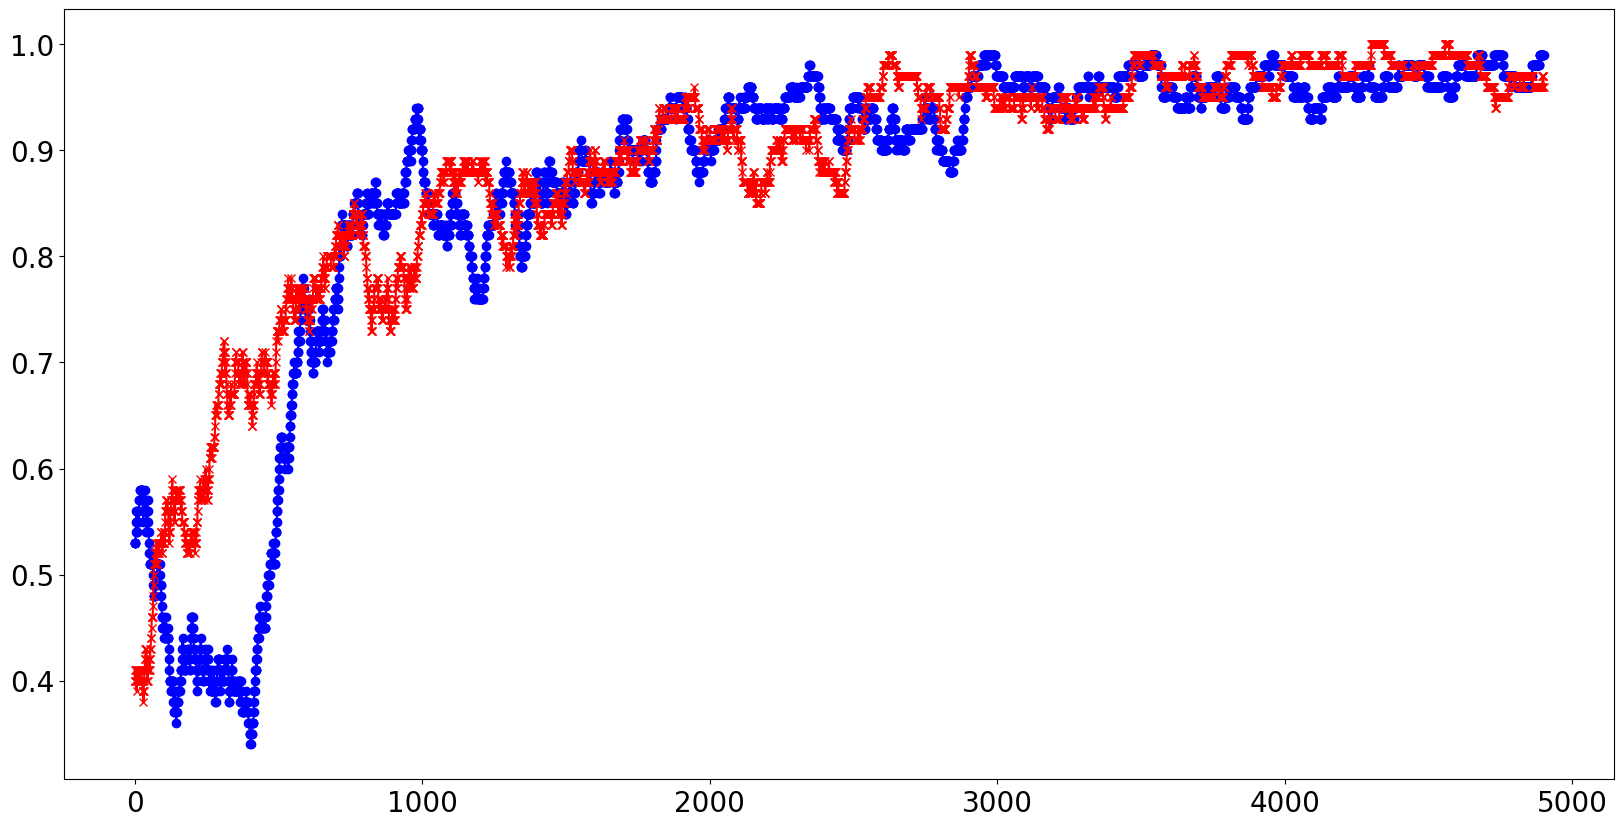

In [9]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams['font.size']=20
plt.plot(moving_average(np.array(actions)[:,0],100), label = 'Agent 1 Actions', marker = 'o', c = 'b')
plt.plot(moving_average(np.array(actions)[:,1],100), label = 'Agent 2 Actions', marker = 'x', c = 'r')
#plt.title('Fraction of Co-operations in 100 games') 
plt.show()

- Almost immediately the value of C is recognized
- Gradually both end up at (C,C)
- No discounting